In [1]:
# general dependencies
import numpy as np
import pandas as pd
import mne
import os
from glob import glob
from itertools import compress
from tqdm import tqdm

In [2]:
from platform import python_version
python_version()

'3.7.5'

In [3]:
import pycwt as wavelet
from pycwt.helpers import find

In [4]:
import io
from copy import copy
from collections import OrderedDict
import requests

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [6]:
# LCBD dependencies
# add relative path to our toolbox
import sys
sys.path.append('../../../..')
from LCBDtools.scripts import argParser
from LCBDtools.src import Plots

In [7]:
# Some configuration variables
study_dir = "/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean"
participant_num_len = 4 # default length of participant numbers
ex_subs = [] # any subjects to not include in the dataset

# set block durations
durations = {
    'Block 1': 120,
    'Block 2': 105,
    'Block 3': 120}

In [8]:
# set the channels for each ROI
ROIs = {
    'Left Frontal': ['S3_D2 hbo', 'S4_D2 hbo'],
    'Right Frontal': ['S5_D3 hbo', 'S6_D3 hbo'],
    'Left Temporal': ['S1_D1 hbo', 'S2_D1 hbo', 'S2_D2 hbo'],
    'Right Temporal': ['S7_D3 hbo', 'S7_D4 hbo', 'S8_D4 hbo']}

In [16]:
# make a list of all matching session paths
session_dirs = [d for d in glob(study_dir+"/*/*_fNIRS")]

subjects = list(set([os.path.basename(d)[:participant_num_len] for d in session_dirs]))

In [17]:
session_dirs

['/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5016_N/5016_N_Child_fNIRS',
 '/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5016_N/5016_N_Parent_fNIRS',
 '/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5098_N/5098_N_Parent_fNIRS',
 '/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5098_N/5098_N_Child_fNIRS',
 '/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5124_N/5124_N_Child_fNIRS',
 '/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5124_N/5124_N_Parent_fNIRS',
 '/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5082_N/5082_N_Parent_fNIRS',
 '/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5082_N/5082_N_Child_fNIRS',
 '/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5075_N/5075_N_Child_fNIRS',
 '/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5075_N/5075_N_Parent_fNIRS',
 '/data/perlman/moochie/analysis/eDOC_NARSAD/NIRS_data_clean/5065_N/5065_N_Parent_fNIRS',
 '/data/perlman

In [18]:
len(session_dirs)

154

In [19]:
# make a list where all of the scans will get loaded into
scans = []

# loop over all the session directories (dyads / DB-DOS folders)
for dyad_dir in list(set([os.path.split(ses)[0] for ses in session_dirs])):
    try:
        
        # get subject and visit from this path
        sub = os.path.basename(dyad_dir)[:participant_num_len]
        visit = os.path.basename(dyad_dir)

        # determining whether sub is Child or Parent can be done by reading the config file in the .nirx directory        
        config_files = glob(os.path.join(dyad_dir, "*fNIRS", "*config*"))

        # open the file and read the line with Subject= in it
        for config in config_files:
            with open(config, 'r') as f:
                line = f.readline()
                while "Subject=" not in line:
                    line = f.readline()
                line = line.strip()
                line = line.replace("Subject=", "")
                
                # if the line is 1 it's the child
                if line == "1":
                    sub1 = os.path.dirname(config) # child
                elif line == "2":
                    sub2 = os.path.dirname(config) # parent
                    
        # make sure it has 'modern' .evt files
        evts = glob(sub1 + "/*.evt")
        if len(evts) != 2:
            print("There should be 2 evt files. Skipping:", os.path.basename(sub1))
            continue

#         # load each in via hypyp loader
        fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
        fnirs_participant_1.info['subject_info']['his_id'] = f"{sub[:participant_num_len]}c"
        
        fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
        fnirs_participant_2.info['subject_info']['his_id'] = f"{sub[:participant_num_len]}p"
        
        scans.append((fnirs_participant_1, fnirs_participant_2))
        
    except:
        print("skipping session:", dyad_dir)
        continue

/tmp/ipykernel_43254/643734704.py:37: RuntimeWarning: Omitted 3 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
/tmp/ipykernel_43254/643734704.py:40: RuntimeWarning: Omitted 3 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent
/tmp/ipykernel_43254/643734704.py:37: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
/tmp/ipykernel_43254/643734704.py:40: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


There should be 2 evt files. Skipping: 5143_N_Child_fNIRS


/tmp/ipykernel_43254/643734704.py:37: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_1 = mne.io.read_raw_nirx(sub1, preload=False, verbose="warning") # child
/tmp/ipykernel_43254/643734704.py:40: RuntimeWarning: Omitted 1 annotation(s) that were outside data range.
  fnirs_participant_2 = mne.io.read_raw_nirx(sub2, preload=False, verbose="warning") # parent


In [20]:
len(scans)

76

In [21]:
# sets X value for data - gives data as an array below
X = scans[0][0].get_data()

In [22]:
# finds time index
t = scans[0][0].times

In [23]:
scans[0][0].ch_names

['S1_D1 760',
 'S1_D1 850',
 'S2_D1 760',
 'S2_D1 850',
 'S2_D2 760',
 'S2_D2 850',
 'S3_D2 760',
 'S3_D2 850',
 'S4_D2 760',
 'S4_D2 850',
 'S5_D3 760',
 'S5_D3 850',
 'S6_D3 760',
 'S6_D3 850',
 'S7_D3 760',
 'S7_D3 850',
 'S7_D4 760',
 'S7_D4 850',
 'S8_D4 760',
 'S8_D4 850']

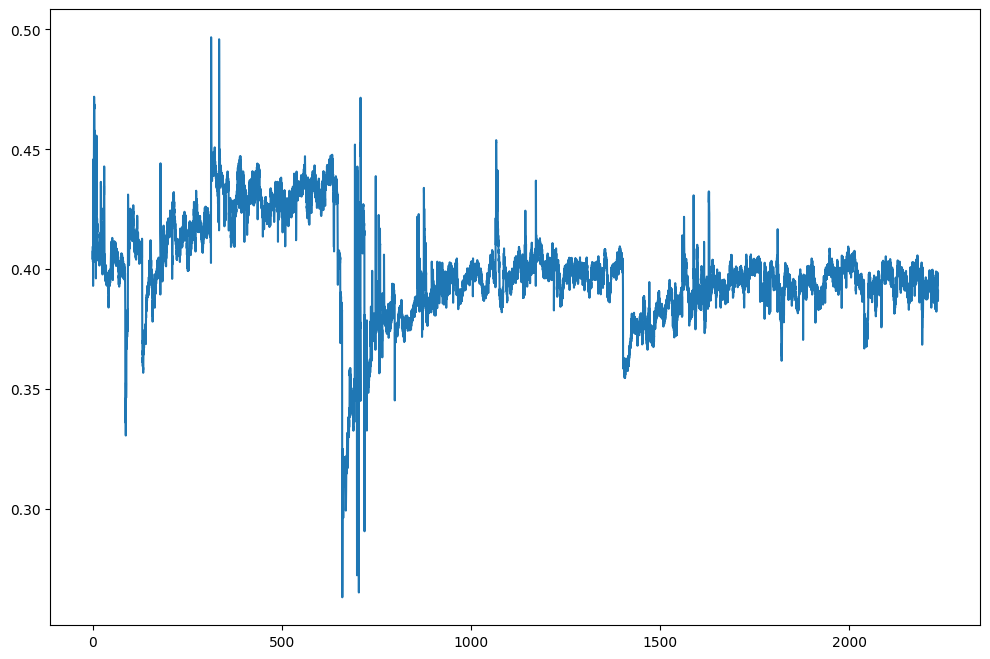

In [24]:
# plotting 10th channel
plt.plot(
    t,
    X[10]
)

In [25]:
scans[2][0].info['subject_info']

{'his_id': '5032c',
 'first_name': '5032-child',
 'sex': 0 (FIFFV_SUBJ_SEX_UNKNOWN),
 'birthday': (2021, 9, 28)}

In [26]:
scans[2][0].annotations

<Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>

In [27]:
for scan in scans:
    print(scan[0].info['subject_info']['his_id'],scan[0].annotations)


5025c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5056c <Annotations | 21 segments: 1.0 (4), 128.0 (10), 2.0 (4), 4.0 (3)>
5032c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5103c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5082c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5003c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5044c <Annotations | 23 segments: 1.0 (4), 128.0 (11), 2.0 (4), 4.0 (4)>
5049c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5063c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5064c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5137c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5097c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5033c <Annotations | 24 segments: 1.0 (4), 128.0 (12), 2.0 (4), 4.0 (4)>
5073c <Annotations | 24 segments: 1.0 (4), 128.0 (1

In [28]:
# rename events and set durations for block 1 and 2

# if we can't load in the annotations right, we'll remove them from our list of scans
bads = []

for i, dscan in enumerate(scans):
    
    try:
        for scan in dscan:

            # rename the binary annotations with actual names
            scan.annotations.rename({
                '1.0': 'Block 1',
                '2.0': 'Block 2',
                '4.0': 'Block 3'})

            # remove any stop annotations
            scan.annotations.delete(scan.annotations.description == '128.0')

            # set the durations based off the durations dictionary
            scan.annotations.set_durations(durations, verbose=True)
    
    except:
        bads.append(i)
        
for i in sorted(bads, reverse=True):
    del scans[i]

In [29]:
scans[0][0].annotations

<Annotations | 12 segments: Block 1 (4), Block 2 (4), Block 3 (4)>

In [30]:
from typing import Union

# function to do Continuous Wavelet Transform on a single signal
def mne_wavelet_transform(sig1: [mne.io.Raw, mne.Epochs], plot: bool = True,
                      chs: Union[str] = None):
    """
    Perform a continuous wavelet transform based off data in mne Raw object
    """
    
    # set time ##t0 = start time and dt = distance in time from t0. N is length
    t0 = sig1.times[0]
    dt = sig1.times[1] - t0
    N = len(sig1.times)
#     t = np.arange(0, N) * dt + t0
    t = sig1.times
    
    # define wavelet analysis parameters ## Clayton Add reference for parameters? 
    mother = wavelet.Morlet(6)
    s0 = 2 * dt # starting scale, in this case 2 * 0.128 s = 0.256 s
    dj = 1 / 12 # twelve sub-octaves per octaves
    J = 10 / dj # ten powers of 2 with dj sub-octaves
    
    if chs is None:
        chs = sig1.info['ch_names']
    
    for ch in chs:
        dat = np.squeeze(sig1.get_data(picks=[ch])) * 1e5
        
        # detrend and normalize the input data by its standard deviation
        p = np.polyfit(t - t0, dat, 1)
        dat_notrend = dat - np.polyval(p, t - t0)
        std = dat_notrend.std() # standard deviation
        var = std ** 2 # variance
        dat_norm = dat_notrend / std # normalized dataset
        
        alpha, _, _ = wavelet.ar1(dat) # lag-1 autocorrelation for red noise
        
        wave, scales, freqs, coi, fft, fftfreqs = wavelet.cwt(
            dat_norm, dt, dj, s0, J, mother)
        iwave = wavelet.icwt(wave, scales, dt, dj, mother) * std
    
        power = (np.abs(wave)) ** 2
        fft_power = np.abs(fft) ** 2
        period = 1 / freqs
        power /= scales[:, None] # optional according to Liu et al. (2007)
        
        # power significance test
        signif, fft_theor = wavelet.significance(
            1.0, dt, scales, 0, alpha,
            significance_level=0.95, 
            wavelet=mother)
        sig95 = np.ones([1, N]) * signif[:, None]
        sig95 = power / sig95
        
        # calculate global wavelet spectrum and determine its significance level
        glbl_power = power.mean(axis=1)
        dof = N - scales # correction for padding at edges
        glbl_signif, tmp = wavelet.significance(var, dt, scales, 1, alpha,
                                                significance_level=0.95, dof=dof,
                                                wavelet=mother)
        
        # calculate scale average and its significance level
        sel = find((period >= 10) & (period < 50))
        Cdelta = mother.cdelta
        scale_avg = (scales * np.ones((N, 1))).transpose()
        scale_avg = power / scale_avg # As in Torrence and Compo (1998) equation 24
        scale_avg = var * dj * dt / Cdelta * scale_avg[sel, :].sum(axis=0)
        scale_avg_signif, tmp = wavelet.significance(var, dt, scales, 2, alpha,
                                                    significance_level=0.95,
                                                    dof=[scales[sel[0]],
                                                        scales[sel[-1]]],
                                                    wavelet=mother)
        
        if plot is True:
            
            title = f"{sig1.info['subject_info']['his_id']} Channel {ch} Continuous Wavelet Transform"
            label = ""
            units = 'Absorbance Units (AU)'
            
            # prepare the figure
            plt.close('all')
            plt.ioff()
            figprops = dict(figsize=(11, 8), dpi=72)
            fig = plt.figure(**figprops)
            
            # first sub-plot, the original time series
            ax = plt.axes([0.1, 0.75, 0.65, 0.2])
            ax.plot(t, dat, 'k', linewidth=1.5)
            ax.set_title('a) {}'.format(title))
            ax.set_ylabel(r'{} [{}]'.format(label, units))
            
            # second sub-plot, the normalized wavelet power spectrum and significance
            # level contour lines and cone of influence hatched area. Note that period
            # scale is logarithmic
            bx = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)
            levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
            conmap = bx.contourf(t, np.log2(period), np.log2(power), np.log2(levels), 
                        extend='both', cmap=plt.cm.jet)
#             plt.colorbar(conmap)
            extent = [t.min(), t.max(), 0, max(period)]
            bx.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
                                  extent=extent)
            bx.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                   t[:1] - dt, t[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
            bx.set_title('b) {} Wavelet Power Spectrum ({})'.format(label, mother.name))
            bx.set_ylabel('Frequency (Hz)')
            
            Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                                    np.ceil(np.log2(period.max())))
            
            bx.set_yticks(np.log2(Yticks))
            bx.set_yticklabels(1/Yticks)
            
            # third sub-plot, the global wavelet and Fourier power spectra and theoretical
            # noise spectra. Note that period scale is logarithmic
            cx = plt.axes([0.77, 0.37, 0.2, 0.28], sharey=bx)
            cx.plot(glbl_signif, np.log2(period), 'k--')
            cx.plot(var * fft_theor, np.log2(period), '--', color='#cccccc')
            cx.plot(var * fft_power, np.log2(1./fftfreqs), '-', color='#cccccc',
                    linewidth=1.)
            cx.plot(var * glbl_power, np.log2(period), 'k-', linewidth=1.5)
            cx.set_title('c) Global Wavelet Spectrum')
            cx.set_xlabel(r'Power [({})^2]'.format(units))
            cx.set_xlim([0, glbl_power.max() + var])
            cx.set_ylim(np.log2([period.min(), period.max()]))
            cx.set_yticks(np.log2(Yticks))
            cx.set_yticklabels(1/Yticks)
            plt.setp(cx.get_yticklabels(), visible=False)
            
            # Fourth sub-plot, the scale averaged wavelet spectrum.
            dx = plt.axes([0.1, 0.07, 0.65, 0.2], sharex=ax)
            dx.axhline(scale_avg_signif, color='k', linestyle='--', linewidth=1.)
            dx.plot(t, scale_avg, 'k-', linewidth=1.5)
            dx.set_title('d) {}--{} second scale-averaged power'.format(2, 8))
            dx.set_xlabel('Time (seconds)')
            dx.set_ylabel(r'Average variance [{}]'.format(units))
            ax.set_xlim([t.min(), t.max()])

            plt.show()
    
    return wave, scales, freqs, coi, fft, fftfreqs


# function to do wavelet coherence transform on 2 signals
def mne_wavelet_coherence_transform(sig1: [mne.io.Raw, mne.Epochs],
        sig2: [mne.io.Raw, mne.Epochs],
        plot: bool = True, fig_fname: str = None,
        chs: Union[str] = None):
    
    t0 = sig1.times[0]
    dt = sig1.times[1] - t0
    N = len(sig1.times)
#     t = np.arange(0, N) * dt + t0
    t = sig1.times
    
    # define wavelet analysis parameters
    mother = wavelet.Morlet(6)
    s0 = 2 * dt # starting scale, in this case 2 * 0.128 s = 0.256 s
    dj = 1 / 12 # twelve sub-octaves per octaves
    J = 10 / dj # ten powers of 2 with dj sub-octaves
    
    if chs is None:
        chs = sig1.info['ch_names']
        
    for ch in chs:
        dat1 = np.squeeze(sig1.get_data(picks=[ch]))
        dat2 = np.squeeze(sig2.get_data(picks=[ch]))
        
        if np.isnan(dat1).any():
            print("Dat 1 contains NaN values")
            raise ValueError
            
        if np.isnan(dat2).any():
            print("Dat 2 contains NaN values")
            raise ValueError
        
        # detrend and normalize the input data by its standard deviation
        p1 = np.polyfit(t - t0, dat1, 1)
        dat_notrend1 = dat1 - np.polyval(p1, t - t0)
        std1 = dat_notrend1.std() # standard deviation
        var1 = std1 ** 2 # variance
        dat_norm1 = dat_notrend1 / std1 # normalized dataset
        
        # detrend and normalize the input data by its standard deviation
        p2 = np.polyfit(t - t0, dat2, 1)
        dat_notrend2 = dat2 - np.polyval(p2, t - t0)
        std2 = dat_notrend2.std() # standard deviation
        var2 = std2 ** 2 # variance
        dat_norm2 = dat_notrend2 / std2 # normalized dataset
        
        WCT, aWCT, coi, freqs, sig95 = wavelet.wct(
            dat_norm1, dat_norm2,
            dt, dj=dj, s0=s0, J=J, sig=False,
            significance_level=0.95, wavelet='morlet',
            normalize=True)
        
        period = 1 / freqs
        
        if plot is True:
            
            title = f"{sig1.info['subject_info']['his_id']} / {sig2.info['subject_info']['his_id']} Channel {ch} Wavelet Coherence Transform"
            label = f"{sig1.info['subject_info']['his_id']} {sig2.info['subject_info']['his_id']} {ch}"
            units = 'Absorbance Units (AU)'
            
            # prepare the figure
            plt.close('all')
            plt.ioff()
            figprops = dict(figsize=(11, 8), dpi=72)
            fig = plt.figure(**figprops)
            
            # first sub-plot, the normalized wavelet power spectrum and significance
            # level contour lines and cone of influence hatched area. Note that period
            # scale is logarithmic
            ax = plt.axes([0.1, 0.37, 0.65, 0.28])
#             levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]
            levels = list(np.arange(0.1, 1, step=0.1))
            conmap = ax.contourf(t, np.log2(period), WCT, levels, 
                        extend='both', cmap=plt.cm.jet)
            plt.colorbar(conmap)
            extent = [t.min(), t.max(), 0, max(period)]
#             ax.contour(t, np.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
#                                   extent=extent)
            ax.fill(np.concatenate([t, t[-1:] + dt, t[-1:] + dt,
                                   t[:1] - dt, t[:1] - dt]),
                    np.concatenate([np.log2(coi), [1e-9], np.log2(period[-1:]),
                                    np.log2(period[-1:]), [1e-9]]),
                    'k', alpha=0.3, hatch='x')
            ax.set_title('b) {} Wavelet Coherence Spectrum ({})'.format(label, mother.name))
            ax.set_ylabel('Frequency (Hz)')
            
            Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                                    np.ceil(np.log2(period.max())))
            
            ax.set_yticks(np.log2(Yticks))
            ax.set_yticklabels(1/Yticks)
            ax.set_xlim([t.min(), t.max()])
            ax.set_ylim(np.log2([period.min(), period.max()]))
            
            if fig_fname is None:
                plt.show()
            else:
                plt.savefig(fig_fname)
            
    return WCT, aWCT, coi, freqs, sig95 

In [31]:
scans[10][1].ch_names

['S1_D1 760',
 'S1_D1 850',
 'S2_D1 760',
 'S2_D1 850',
 'S2_D2 760',
 'S2_D2 850',
 'S3_D2 760',
 'S3_D2 850',
 'S4_D2 760',
 'S4_D2 850',
 'S5_D3 760',
 'S5_D3 850',
 'S6_D3 760',
 'S6_D3 850',
 'S7_D3 760',
 'S7_D3 850',
 'S7_D4 760',
 'S7_D4 850',
 'S8_D4 760',
 'S8_D4 850']

Using matplotlib as 2D backend.


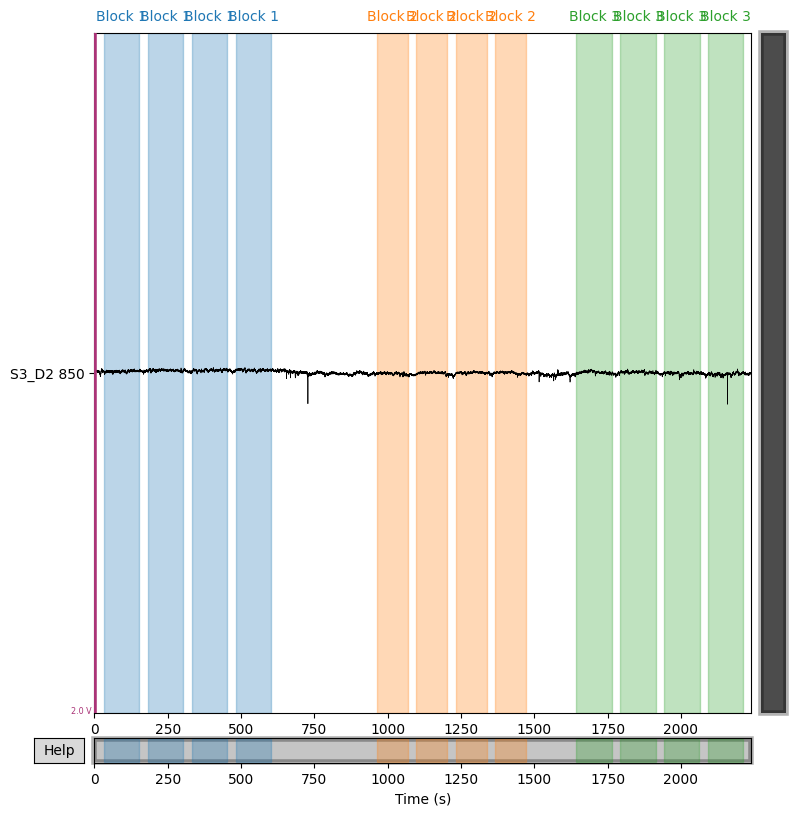

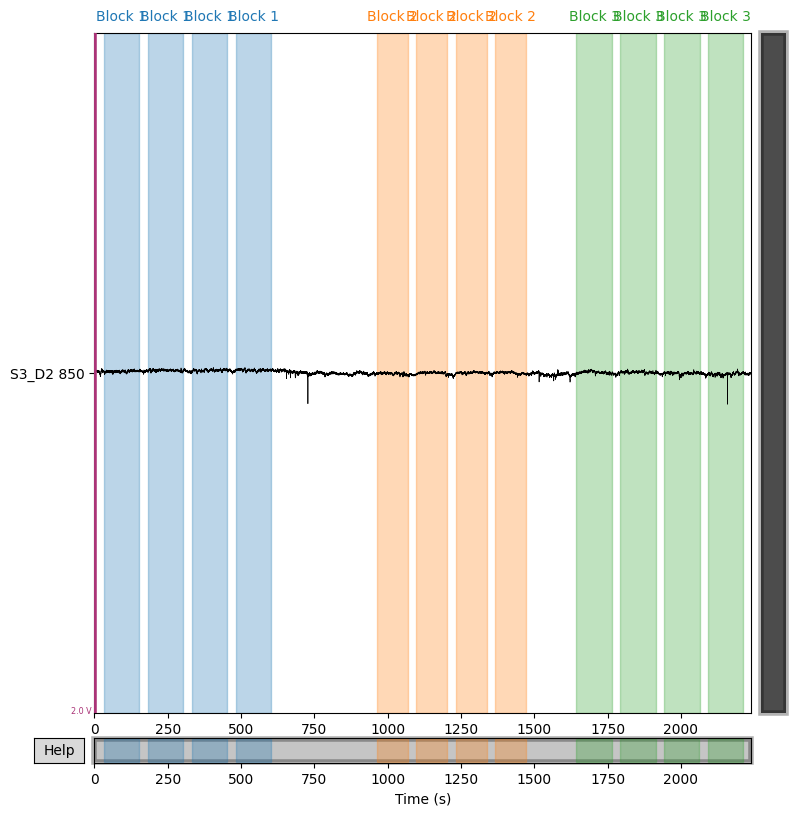

In [32]:
# example plot for 2200 seconds
scans[10][1].copy().pick(['S3_D2 850']).plot(duration=2500, scalings=1)

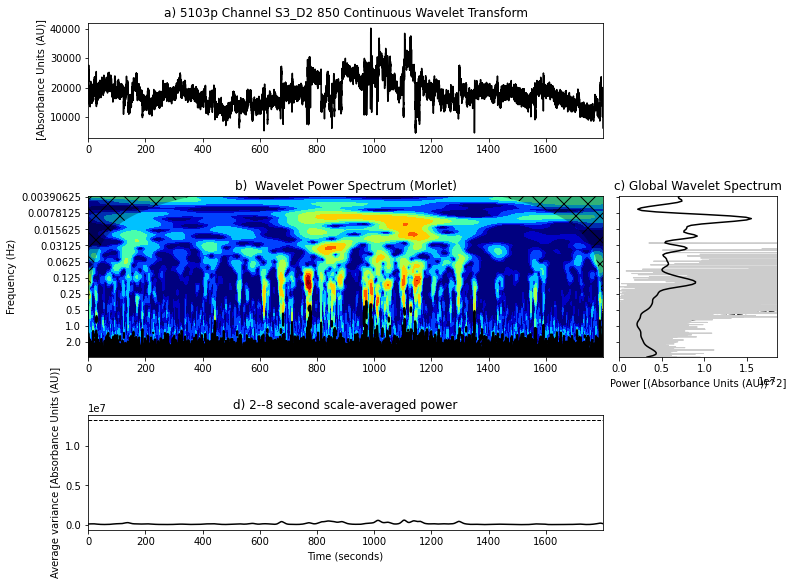

In [33]:
# example wavelet transform for 1900 seconds
wave, scales, freqs, coi, fft, fftfreqs = mne_wavelet_transform(
    scans[3][1].copy().crop(tmax=1800),
    plot=True,
    chs=['S3_D2 850']
)

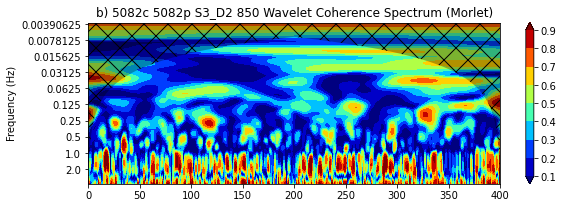

In [34]:
# example coherence transformo from a real dyad with 400 seconds

WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    scans[4][0].copy().pick(['S3_D2 850']).crop(tmax=400),
    scans[4][1].copy().pick(['S3_D2 850']).crop(tmax=400),
    plot=True)

# Preprocessing Step

Now that data are loaded in and events are correctly distinct, we iterate through each dyad and each individual scan to apply LCBD-standard preprocessing functions. 
- Convert to Optical Density
- Record Scalp-Coupling Index and Mark Channels < 0.5
- Temporal Derivative Distribution Repair
- Beer Lambert Law to Convert to Haemoglobin
- Bandpass Filter 0.01-0.5 Hz

and append those dyads to a list of preprocessed scans. 

In [35]:
# make a list where the preprocessed scans will go
pps = []

# for each dyad scan in scans
for dscan in scans:

    ppdscan = [] # make a list for the preprocessed dyad's scans
    
    # individually preprocess each subject in dyad
    for scan in dscan:
        
        # convert to optical density
        raw_od = mne.preprocessing.nirs.optical_density(scan)

        # scalp coupling index
        sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od)
        raw_od.info['bads'] = list(compress(raw_od.ch_names, sci < 0.5))
        
        # linear detrend, par example
#         raw.data[:] = scipy.signal.detrend(raw.get_data(), axis=-1, fit='linear')

        if len(raw_od.info['bads']) > 0:
            print("Bad channels in subject", raw_od.info['subject_info']['his_id'], ":", raw_od.info['bads'])
        
        # temporal derivative distribution repair (motion attempt)
        tddr_od = mne.preprocessing.nirs.tddr(raw_od)
#         print("tddr")
#         tddr_od.plot(
#             n_channels=len(tddr_od.ch_names),
#             scalings=0.1,
#             duration=100,
#             show_scrollbars=False)
        
        # savgol filter (linear polynomial smoothing)
#         sav_od = raw_od.savgol_filter(0.5)
#         print("savgol filtering")
#         sav_od.plot(
#             n_channels=len(sav_od.ch_names),
#             scalings=0.1,
#             duration=100,
#             show_scrollbars=False)

        bp_od = tddr_od.filter(0.01, 0.5)
#         print("bandpass")
#         bp_od.plot(
#             n_channels=len(bp_od.ch_names),
#             duration=100,
#             scalings=0.1,
#             show_scrollbars=False)
    
        # haemoglobin conversion
        haemo = mne.preprocessing.nirs.beer_lambert_law(bp_od, ppf=0.1)
#         print("haemo")
#         haemo.plot(
#             n_channels=len(haemo.ch_names),
#             duration=100,
#             scalings=0.0001,
#             show_scrollbars=False)

#         print("PSD")
#         haemo_lp.plot_psd(average=True)
        
        ppdscan.append(haemo)
        
    pps.append(ppdscan)

Bad channels in subject 5025p : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 5103p : ['S3_D2 760', 'S3_D2 850']
Bad channels in subject 5049p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850', 'S3_D2 760', 'S3_D2 850', 'S4_D2 760', 'S4_D2 850', 'S5_D3 760', 'S5_D3 850', 'S6_D3 760', 'S6_D3 850', 'S7_D4 760', 'S7_D4 850']
Bad channels in subject 5064p : ['S1_D1 760', 'S1_D1 850', 'S2_D1 760', 'S2_D1 850', 'S2_D2 760', 'S2_D2 850']
Bad channels in subject 5137c : ['S5_D3 760', 'S5_D3 850', 'S6_D3 760', 'S6_D3 850', 'S8_D4 760', 'S8_D4 850']
Bad channels in subject 5033c : ['S3_D2 760', 'S3_D2 850']
Bad channels in subject 5033p : ['S8_D4 760', 'S8_D4 850']
Bad channels in subject 5073p : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 5016c : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 5016p : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 5133c : ['S1_D1 760', 'S1_D1 850']
Bad channels in subject 5132c : ['S3_D2 760', 'S3_D2 850']
Bad ch

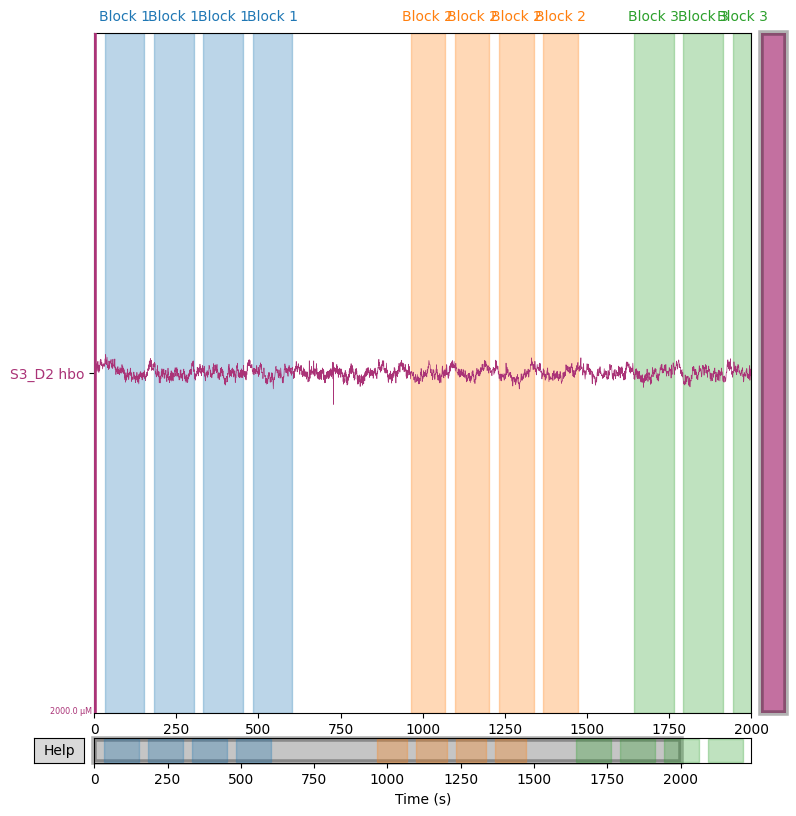

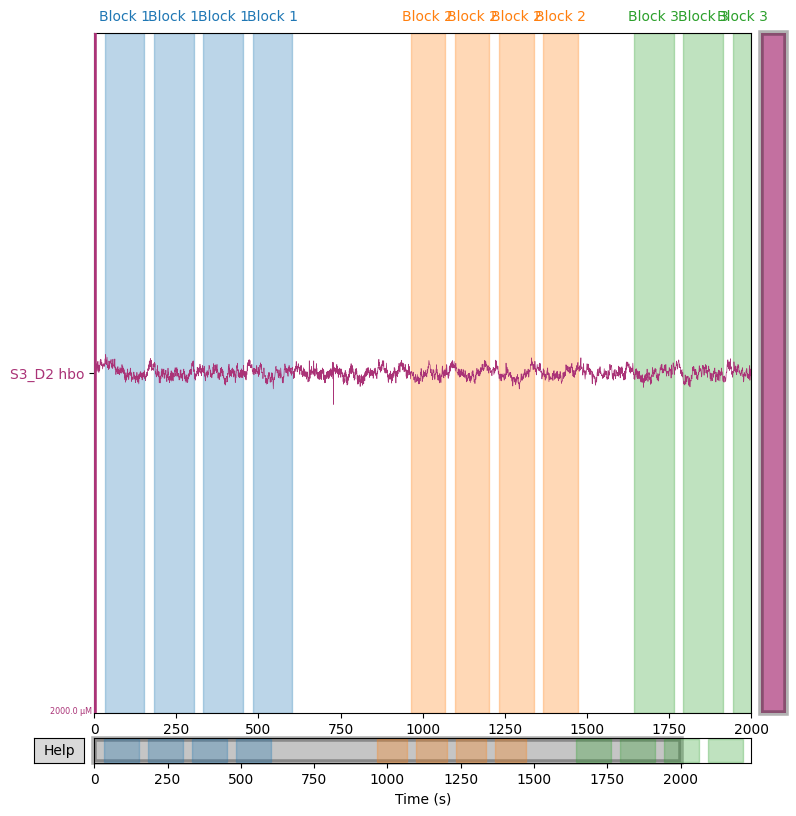

In [36]:
# example plot for 2200 seconds
pps[10][1].copy().pick(['S3_D2 hbo']).plot(duration=2000, scalings=0.001)

In [37]:
sampling_rate = pps[0][0].info['sfreq']
print(sampling_rate)

7.8125


In [38]:
# make a dictionary where all of the epoch'd data will go
epoch_df = {}

# loop over the dyads in the preprocessed list
for dscan in pps:
    
    # for each scan in the dyad
    for scan in dscan:
    
        # set their location in the epoch df to a dictionary
        epoch_df[scan.info['subject_info']['his_id']] = {}
    
#         for i, ROI in enumerate(ROIs.keys()):

        # loop over ROIs (channels here)
        for i, ROI in enumerate([ch for ch in scan.info['ch_names'] if "hbo" in ch]):
            
            epoch_df[scan.info['subject_info']['his_id']][ROI] = []
        
            # get their events and set block durations
            events, event_dict = mne.events_from_annotations(dscan[0], verbose=False)
            reject_criteria = dict(hbo=200e-6)
            tmin, puzzletmax, playtmax = -5, 105, 120
            
            # use the mne.Epochs function / object to generate epochs
            preplay_epochs = mne.Epochs(
                scan, # the scan object
                events, # its events
#                 picks=ROIs[ROI],
                picks=[ROI], # the channels
                event_id={list(event_dict.keys())[0]: list(event_dict.values())[0]}, # the first event key
                tmin=tmin, # epoch relative start time
                tmax=playtmax, # epoch relative end time
                baseline=(None, 0), # baseline window to subtract
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1, # linear detrend
                verbose=False, 
                preload=False, # don't actually load it yet (saves memory)
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(preplay_epochs)
            
            puzzle_epochs = mne.Epochs(
                scan,
                events,
#                 picks=ROIs[ROI],
                picks=[ROI],
                event_id={list(event_dict.keys())[1]: list(event_dict.values())[1]},
                tmin=tmin,
                tmax=puzzletmax,
                baseline=(None, 0),
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1,
                verbose=False,
                preload=False,
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(puzzle_epochs)
            
            postplay_epochs = mne.Epochs(
                scan,
                events,
#                 picks=ROIs[ROI],
                picks=[ROI],
                event_id={list(event_dict.keys())[2]: list(event_dict.values())[2]},
                tmin=tmin,
                tmax=playtmax,
                baseline=(None, 0),
#                 reject=reject_criteria,
                reject_by_annotation=True,
                detrend=1,
                verbose=False,
                preload=False,
                event_repeated='merge')
            
            epoch_df[scan.info['subject_info']['his_id']][ROI].append(postplay_epochs)

In [39]:
# here is the way to access information in the epoch dictionary

In [40]:
# a single subject 
epoch_df['5064c']

{'S1_D1 hbo': [<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 2': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 3': 4>],
 'S2_D1 hbo': [<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 2': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 3': 4>],
 'S2_D2 hbo': [<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
   'Block 1': 4>,
  <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 se

In [41]:
# a specific channel from the subject
epoch_df['5064c']['S1_D1 hbo']

[<Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 1': 4>,
 <Epochs |  4 events (good & bad), -4.992 - 104.96 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 2': 4>,
 <Epochs |  4 events (good & bad), -4.992 - 120.064 sec, baseline -4.992 – 0 sec, ~13 kB, data not loaded,
  'Block 3': 4>]

In [42]:
# a specific block at that subject / channel, in this case the first (0) is pre-play
epoch_df['5064c']['S1_D1 hbo'][0]

Number of events,4
Events,Block 1: 4
Time range,-4.992 – 120.064 sec
Baseline,-4.992 – 0.000 sec


In [43]:
# a specific iteration of that block at that subject / channel, in this case the first (0) is pre-play, we look at the 4th (3) iteration of the block
epoch_df['5064c']['S1_D1 hbo'][0][3]

Number of events,1
Events,Block 1: 1
Time range,-4.992 – 120.064 sec
Baseline,-4.992 – 0.000 sec


In [44]:
event_dict

{'Block 1': 1, 'Block 2': 2, 'Block 3': 3}

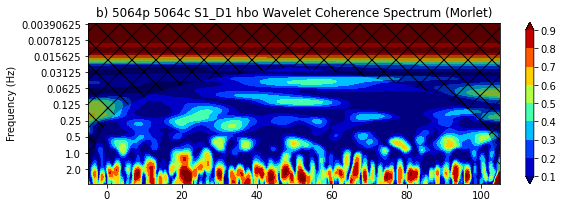

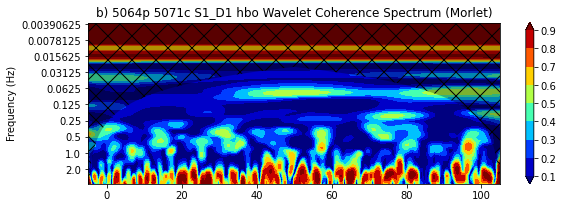

In [45]:
# example WCT between a real dyad, puzzle block (1), iteration 0 (0)
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    epoch_df['5064p']['S1_D1 hbo'][1][0].copy(),
    epoch_df['5064c']['S1_D1 hbo'][1][0].copy(),
    plot=True)

# same WCT but a random false dyad
WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
    epoch_df['5064p']['S1_D1 hbo'][1][0].copy(),
    epoch_df['5071c']['S1_D1 hbo'][1][0].copy(),
    plot=True)

In [46]:
# list out all the subjects in the epoch df
epoch_df.keys()

dict_keys(['5025c', '5025p', '5056c', '5056p', '5032c', '5032p', '5103c', '5103p', '5082c', '5082p', '5003c', '5003p', '5044c', '5044p', '5049c', '5049p', '5063c', '5063p', '5064c', '5064p', '5137c', '5137p', '5097c', '5097p', '5033c', '5033p', '5073c', '5073p', '5053c', '5053p', '5016c', '5016p', '5133c', '5133p', '5132c', '5132p', '5065c', '5065p', '5040c', '5040p', '5017c', '5017p', '5102c', '5102p', '5060c', '5060p', '5115c', '5115p', '5113c', '5113p', '5100c', '5100p', '5043c', '5043p', '5071c', '5071p', '5150c', '5150p', '5101c', '5101p', '5106c', '5106p', '5020c', '5020p', '5008c', '5008p', '5096c', '5096p', '5005c', '5005p', '5077c', '5077p', '5010c', '5010p', '5090c', '5090p', '5067c', '5067p', '5094c', '5094p', '5138c', '5138p', '5076c', '5076p', '5022c', '5022p', '5055c', '5055p', '5057c', '5057p', '5144c', '5144p', '5119c', '5119p', '5079c', '5079p', '5036c', '5036p', '5098c', '5098p', '5068c', '5068p', '5015c', '5015p', '5083c', '5083p', '5134c', '5134p', '5088c', '5088p',

In [47]:
# delete things we don't need anymore to save memory
del scans
del pps

In [48]:
import random

In [49]:
# ATTENTION READ THE FOLLOWING COMMENT CAREFULLY BEFORE PROCEEDING

In [50]:
# for each parent

    # real kid's synchrony value
    
    # 80 false dyad synchrony values
    
    # 

In [ ]:
# make a new dictionary where the synchrony values will be stored
sync_df = {}
block_types = ['Block 1', 'Block 2', 'Block 3']
perm_df = {}

# THIS TAKES A REALLY LONG TIME TO COMPUTE. PROBABLY 4 HOURS OR MORE.
# SKIP DOWN TO USE THE SAVED VERSIONS!

# for every parent subject
for parent in tqdm([sub for sub in sorted(epoch_df.keys()) if "p" in sub]):
    sync_df[parent] = {}
    perm_df[parent] = []
    
    # pick two children, one real and one random
    children = []
    
#     children.append(parent.replace("p", "c")) # real child
    
    # random sample of N children
    # could be repeated, could be the real dyad
    randoms = random.choices(
        [sub for sub in epoch_df.keys() if "c" in sub],
        k=1000) # N of random 
    perm_df[parent] = list(randoms)
    
    # only going to do synchrony once per kid
    # we can count # of repeats from perm_df[parent]
    for child in list(set(randoms)):
        children.append(child)
    
    # old version that just does 1 random non-real child per parent
#     children.append(
#         random.choice([sub for sub in epoch_df.keys() if "c" in sub \
#             and parent.replace("p", "") not in sub])) # random pick
    
    # loop over these 2 selected children (1 real, N random)
    for child in children:
        
        # and make them a location in the sync dictionary under this parent
        sync_df[parent][child] = {}
        
        # for every block type (pre-play, puzzle, post-play)
        for block_num, block in enumerate(block_types):
            
            # make this parent/child combo a location for this block type, also a dictionary
            sync_df[parent][child][block] = {}
                
            # for each channel available with this subject (not dropped)
            for ch in epoch_df[parent].keys():
                
                # our sync value is going to go here
                # sync_df[parent][child][block][ch]
                # i.e. averaging over the 4 block iterations
                
                # so start keeping track of values to average now
                pc_wcts = []
                
                # load in their epoched data for this subject / channel / block
                p_epoch = epoch_df[parent][ch][block_num].load_data()
                c_epoch = epoch_df[child][ch][block_num].load_data()
                
                # for each iteration of this block (max 4)
                for block_it in np.arange(0, np.min([
                    len(p_epoch),
                    len(c_epoch)])):
                    
                    # try to do the WCT with these epochs
                    try:
                        WCT, aWCT, coi, freqs, sig95 = mne_wavelet_coherence_transform(
                            p_epoch[block_it],
                            c_epoch[block_it],
                            plot=True if "S5_D3" in ch else False, # save plots but only for some random channel because otherwise it's an insane amount
                            fig_fname=f"/data/perlman/moochie/analysis/eDOC_NARSAD/sync_figs/{parent}_{child}_{ch.replace(' ', '_')}_{block_num}_{block_it}.png")

                        # make values outside COI = np.nan
                        nanWCT = WCT
                        for t in range(nanWCT.shape[1]):
                            nanWCT[np.where(freqs>coi[t]), t] = np.nan
                        # also set to nan outside frequencies of interest
                        # periods == 2s to 20s
                        
                        # TASK RELATED FREQUENCIES ARE ARBITRARILY DETERMINED right here baby
                        WCT[(2>(1/freqs))|((1/freqs)>13), :] = np.nan
                        # between periods of 2s and 13s. 

                        # average inside cone of influence
                        # and within values from freq range determined above
                        pc_wcts.append(np.nanmean(nanWCT))
    #                     print(np.nanmean(nanWCT))
    
                    # if anything with the WCT fails, say so
                    except:
                        print(f"Fail @ parent {parent}, child {child}, block {block}, channel {ch}, block it {block_it}")
#                 print(np.average(pc_wcts))  
                sync_df[parent][child][block][ch] = np.average(pc_wcts)

 28%|██████████▌                           | 21/76 [3:48:43<9:44:32, 637.67s/it]

In [ ]:
# skip if you're going to load the already-saved ones. for real. don't overwrite this with an empty data file. 
# SAVE SYNCHRONY VALUES

import json
json_object = json.dumps(sync_df, indent=4)

with open("/data/perlman/moochie/analysis/eDOC_NARSAD/wct_permuted_values.json", 'w') as outfile:
    json.dump(sync_df, outfile)

In [275]:
# save permuted values

json_object = json.dumps(perm_df, indent=4)
with open("/data/perlman/moochie/analysis/eDOC_NARSAD/permuted_subjects.json", 'w') as outfile:
    json.dump(perm_df, outfile)

In [9]:
# LOAD PERMUTED SYNCHRONY VALUES from the saved file, saving time and precious CPU-hours

import json
with open("/data/perlman/moochie/analysis/eDOC_NARSAD/wct_permuted_values.json", 'r') as infile:
    perm_sync_df = json.load(infile)

In [11]:
# LOAD PERMUTED SYNCHRONY VALUES from the saved file, saving time and precious CPU-hours

import json
with open("/data/perlman/moochie/analysis/eDOC_NARSAD/permuted_subjects.json", 'r') as infile:
    perm_df = json.load(infile)

In [12]:
# LOAD REAL SYNCHRONY VALUES from the saved file, saving time and precious CPU-hours

import json
with open("/data/perlman/moochie/analysis/eDOC_NARSAD/wct_values.json", 'r') as infile:
    sync_df = json.load(infile)

In [62]:
# pull out all of the real dyad values from the original synchrony dataframe
dyad_syncs = []

for parent in sync_df.keys():
    # average sync values over all channels for some block
    for ch in list(sync_df[parent][list(sync_df[parent].keys())[0]]['Block 1'].keys()): # for first child (real)
        dyad_syncs.append(
            sync_df[parent][list(sync_df[parent].keys())[0]]['Block 1'][ch])

In [69]:
list(epoch_df['5025c'].keys())

['S1_D1 hbo',
 'S2_D1 hbo',
 'S2_D2 hbo',
 'S3_D2 hbo',
 'S4_D2 hbo',
 'S5_D3 hbo',
 'S6_D3 hbo',
 'S7_D3 hbo',
 'S7_D4 hbo',
 'S8_D4 hbo']

In [84]:
# pull out all of the real dyad values from the original synchrony dataframe
dyad_syncs = {}
block_of_interest = 'Block 1'

for ch in list(epoch_df['5025c'].keys()): # iterate over channels from a random subject's epoch keys
    
    dyad_syncs[ch] = [] # initialize as a list
    
    for parent in sync_df.keys(): # iterate over parents
        
        dyad_syncs[ch].append(
            sync_df[parent][list(sync_df[parent].keys())[0]][block_of_interest][ch]) # 0 here is "real child" 
        # append sync values from "block of interest" to this channel slot of the dyad_syncs dictionary

        
# using the averaging method
# pull out all of the permuted dyad values from the random pair synchrony dataframe
nyad_syncs = {}

for ch in list(epoch_df['5025c'].keys()): # iterate over channels from a random subject's epoch keys
    
    nyad_syncs[ch] = [] # initialize as a list
    
    for parent in perm_sync_df.keys(): # iterate over parents
        
        syncs_to_average = [] # averages over all the children who were randomly assigned to that parent
        # currently set to N = 40
        # some of them are repeated
        for child in perm_df[parent]:
            
            sync = perm_sync_df[parent][child][block_of_interest][ch]
            syncs_to_average.append(sync)
            
        nyad_syncs[ch].append(np.average(syncs_to_average))
        
        # append sync values from "block of interest" to this channel slot of the dyad_syncs dictionary

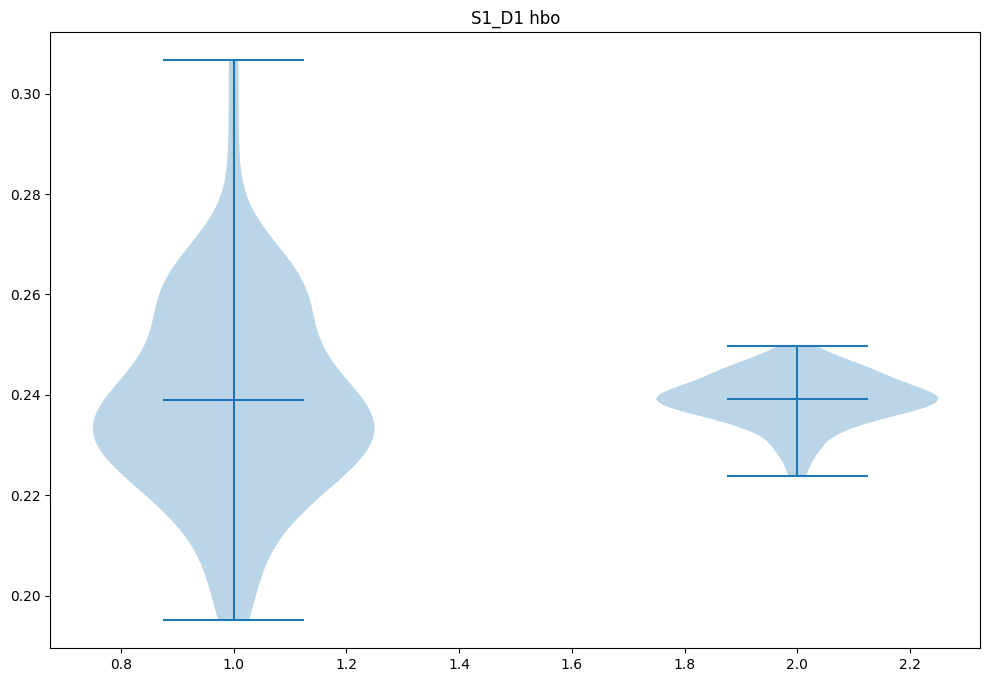

T statistic for S1_D1 hbo: -0.05880411184107704
P Value for S1_D1 hbo: 0.9531864003903018


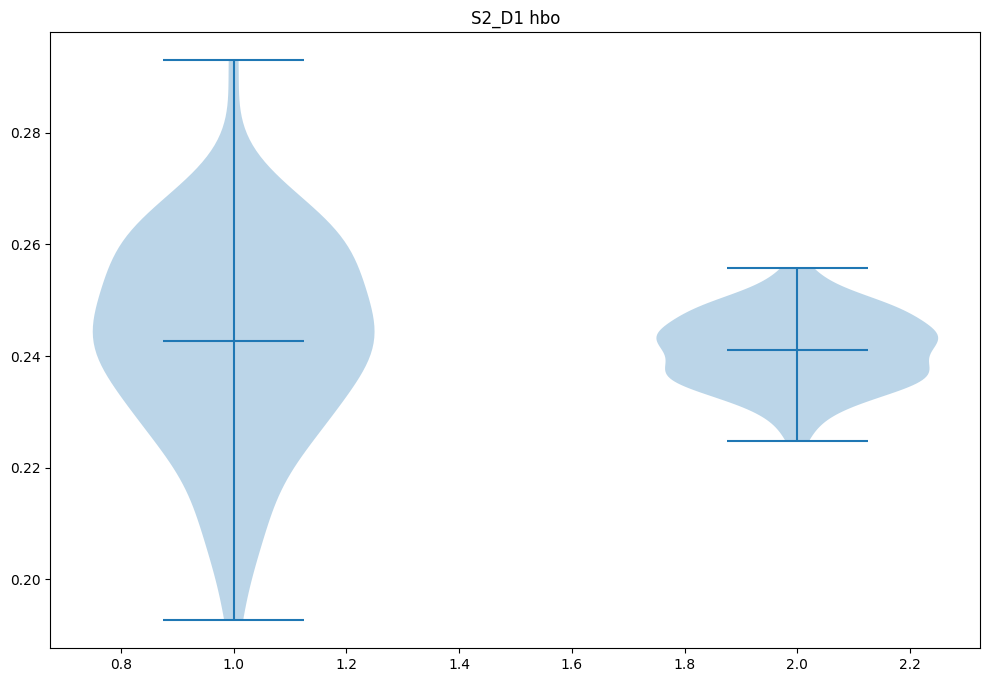

T statistic for S2_D1 hbo: 0.7446797131691659
P Value for S2_D1 hbo: 0.45763047471263263


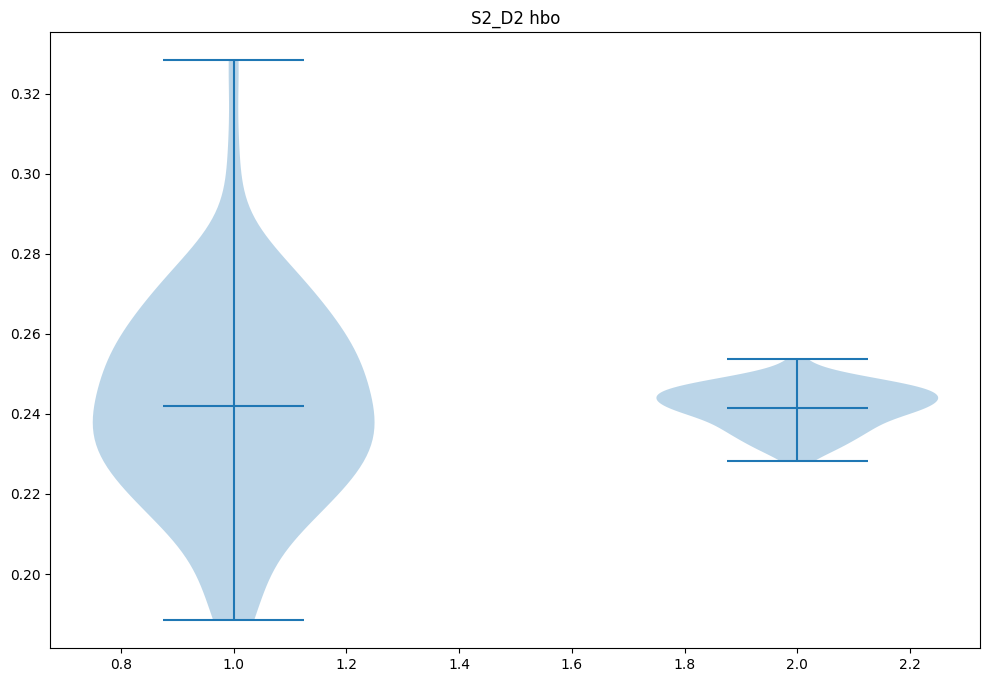

T statistic for S2_D2 hbo: 0.1679329737932467
P Value for S2_D2 hbo: 0.8668622165822524


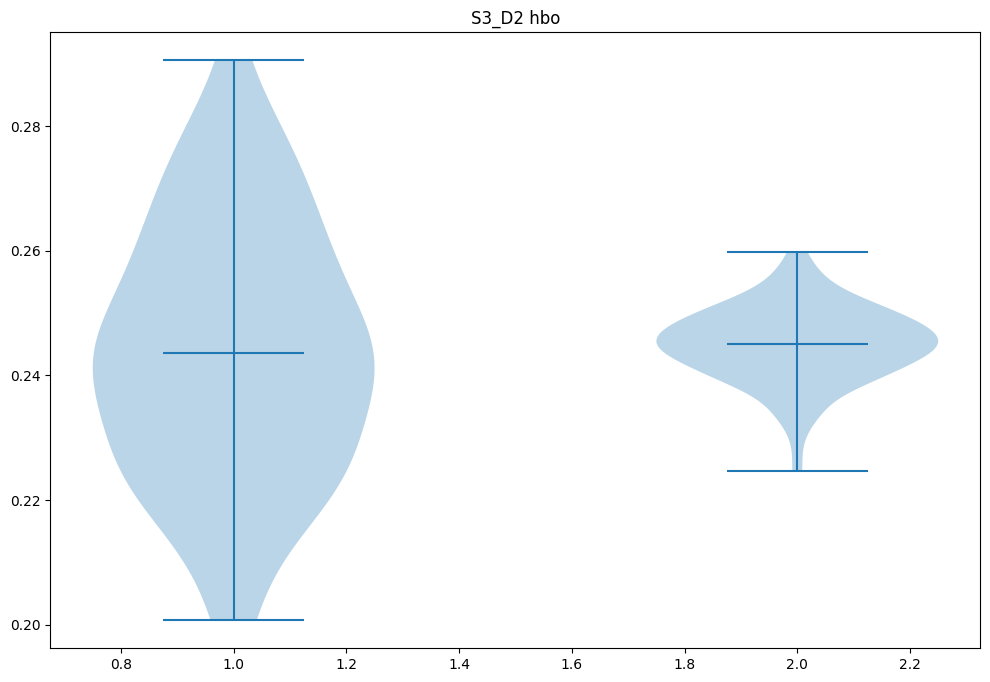

T statistic for S3_D2 hbo: -0.5804206084983725
P Value for S3_D2 hbo: 0.5625019460244121


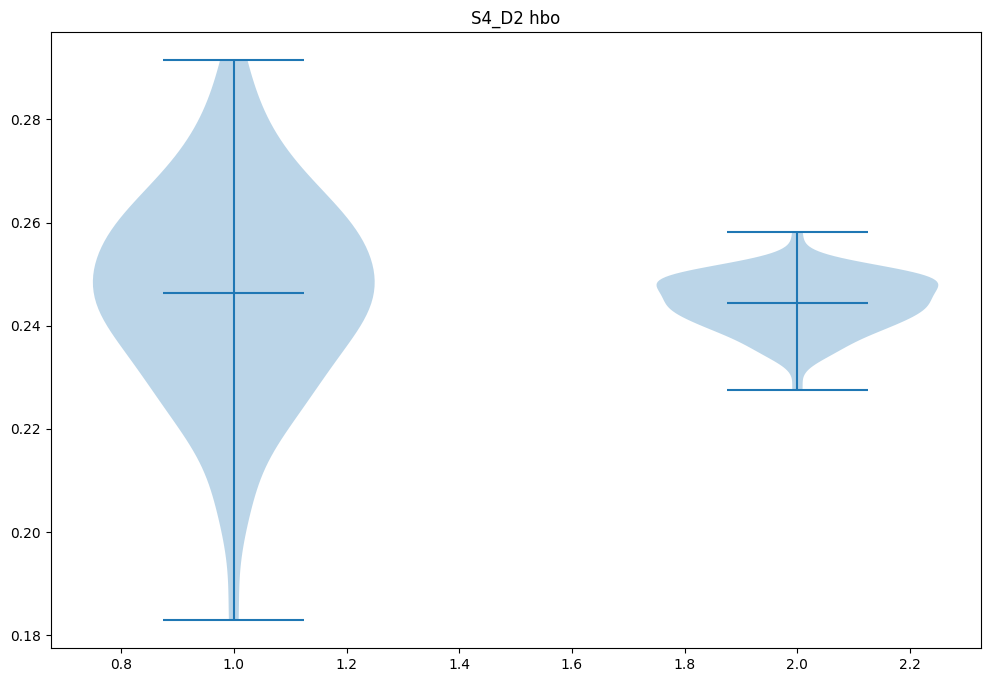

T statistic for S4_D2 hbo: 0.7719365921944327
P Value for S4_D2 hbo: 0.4413664437134316


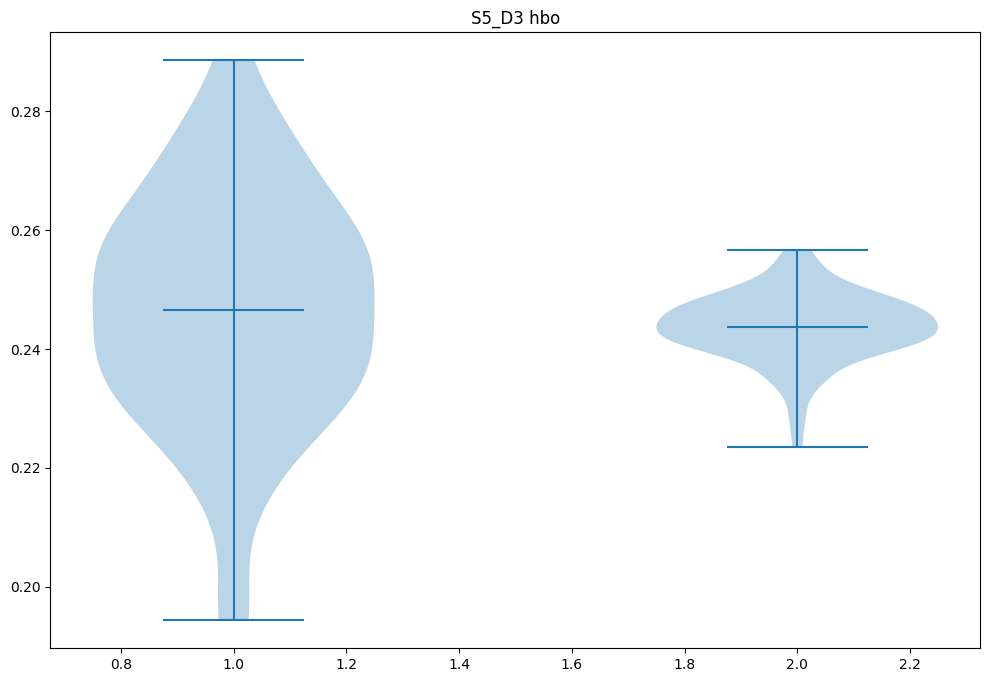

T statistic for S5_D3 hbo: 1.1978696895382728
P Value for S5_D3 hbo: 0.2328571126650459


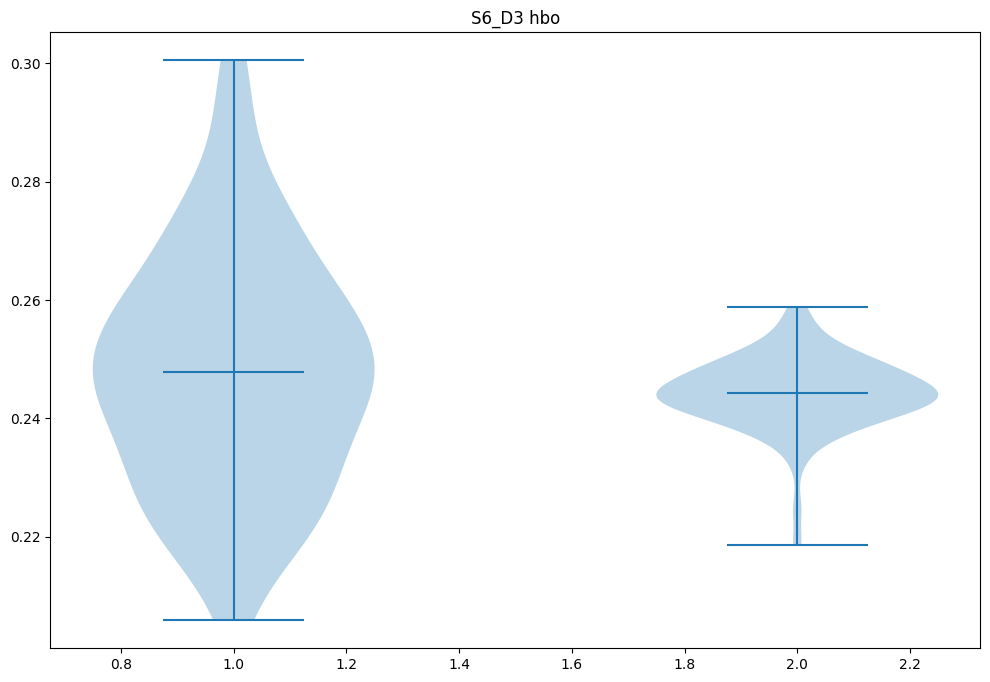

T statistic for S6_D3 hbo: 1.437565462736191
P Value for S6_D3 hbo: 0.1526402256074261


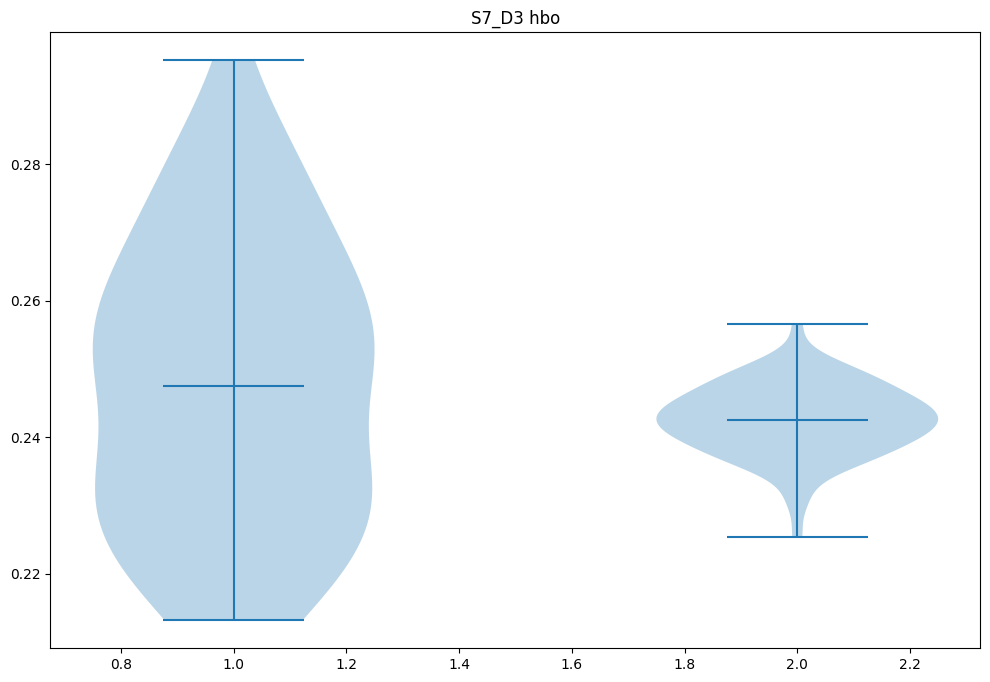

T statistic for S7_D3 hbo: 2.0037136430261975
P Value for S7_D3 hbo: 0.0469014054549479


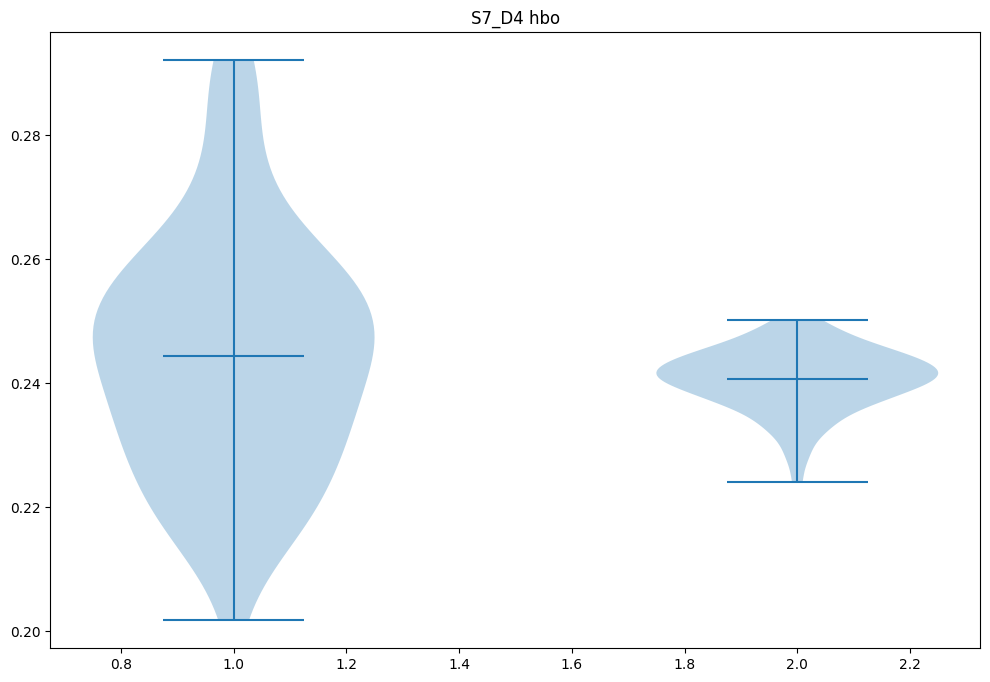

T statistic for S7_D4 hbo: 1.581392964930403
P Value for S7_D4 hbo: 0.11589452337460007


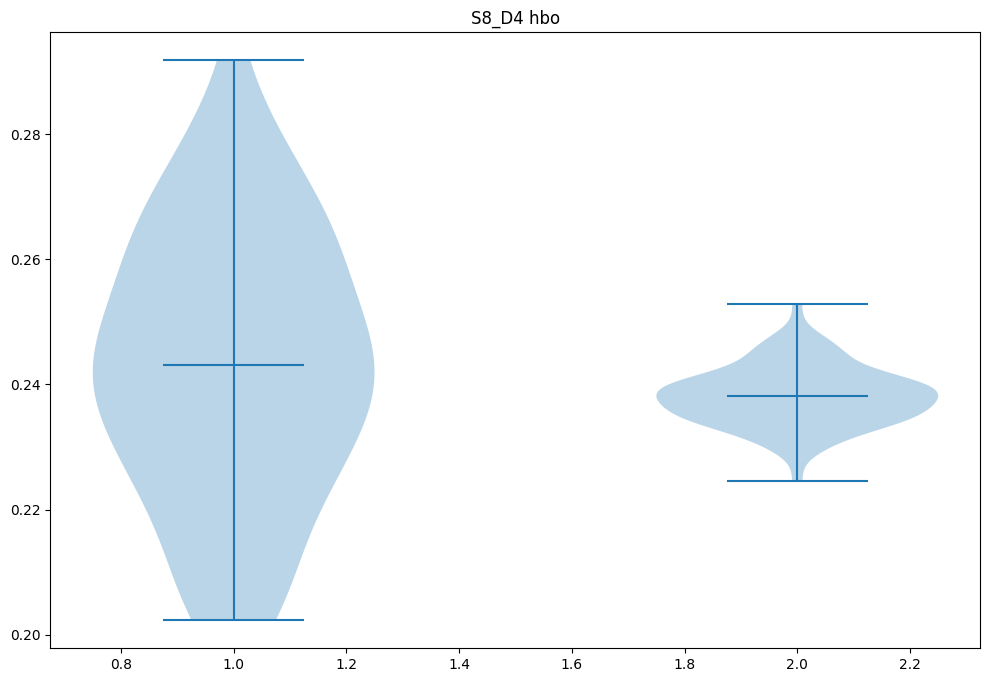

T statistic for S8_D4 hbo: 1.9526599701424754
P Value for S8_D4 hbo: 0.05272155410365028


In [96]:
# channel_of_interest = 'S1_D1 hbo'
for channel_of_interest in list(epoch_df['5025c'].keys()):

    plt.clf()
    plt.violinplot([
        dyad_syncs[channel_of_interest],
        nyad_syncs[channel_of_interest]],
        showmeans=True,
    #     showmedians=True,
    )
    plt.title(channel_of_interest)
    plt.show()
    

    from scipy.stats import ttest_ind

    statistic, pvalue = ttest_ind(
        dyad_syncs[channel_of_interest],
        nyad_syncs[channel_of_interest])

    print("T statistic for {}:".format(channel_of_interest), statistic)

    print("P Value for {}:".format(channel_of_interest), pvalue)

In [240]:
epoch_df['5025c'].keys()

dict_keys(['S1_D1 hbo', 'S2_D1 hbo', 'S2_D2 hbo', 'S3_D2 hbo', 'S4_D2 hbo', 'S5_D3 hbo', 'S6_D3 hbo', 'S7_D3 hbo', 'S7_D4 hbo', 'S8_D4 hbo'])

In [63]:
# pull out all of the real dyad values from the original synchrony dataframe
channel_of_interest = 'S1_D1 hbo'
blocks = ['Block 1', 'Block 2', 'Block 3']

dyad_syncs = {}

for block in blocks: 
    
    dyad_syncs[block] = []
    
    for parent in sync_df.keys(): # iterate over parents
    
        dyad_syncs[block].append(
            #   df  [   parent         real child                    block                 channel    ]
            sync_df[parent][list(sync_df[parent].keys())[0]][block][channel_of_interest]) # 0 here is "real child" 

# using the averaging method
# pull out all of the permuted dyad values from the random pair synchrony dataframe
nyad_syncs = [] # initialize as a list

# loop over all the randomly assigned children
for i in range(1000):

    for parent in perm_sync_df.keys(): # iterate over parents

        for block in blocks:
        
            nyad_syncs.append(
                #   df  [   parent    the ith permuted child     block           channel    ]
                perm_sync_df[parent][perm_df[parent][i]][block][channel_of_interest]) # 0 here is "real child" 

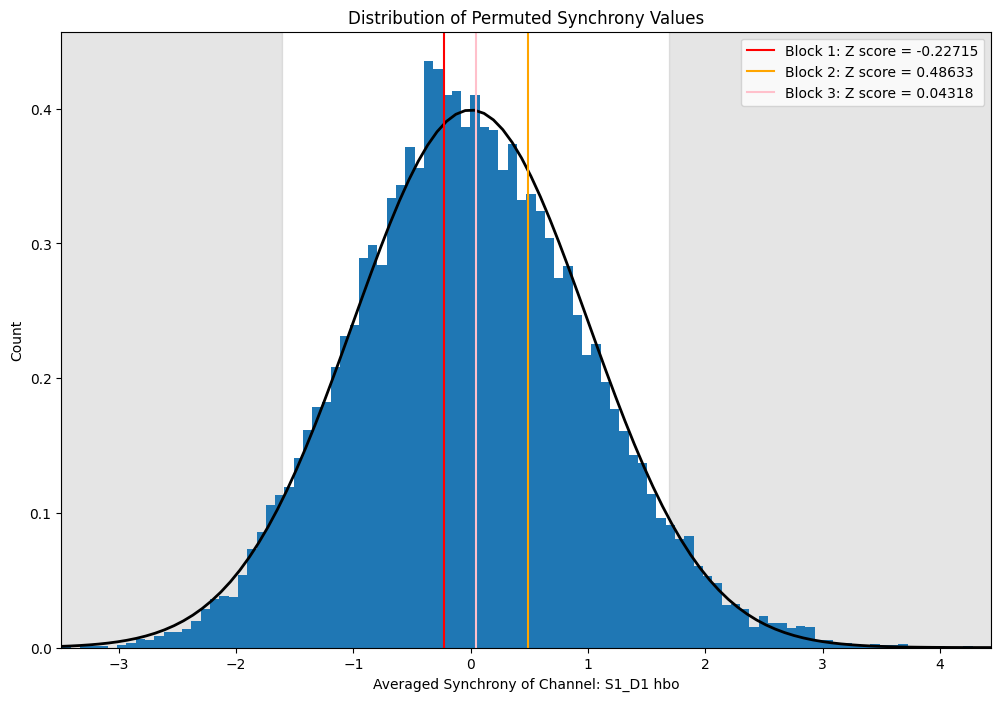

In [65]:
import scipy.stats as st
from scipy.stats import ttest_ind
from scipy.stats import norm
from statsmodels.stats.multitest import fdrcorrection as fdr

colors = ['red', 'orange', 'pink']

# CI = st.norm.interval(alpha=0.95, loc=np.mean(nyad_syncs), scale=st.sem(nyad_syncs))
# print(CI)

plt.clf()

# convert to z scores
z_nyad_syncs = (np.array(nyad_syncs) - np.mean(nyad_syncs)) / np.std(nyad_syncs)
z_dyad_syncs = {}
for block in dyad_syncs.keys():
    z_dyad_syncs[block] = (np.array(dyad_syncs[block]) - np.mean(nyad_syncs)) / np.std(nyad_syncs)

xmin, xmax = min(z_nyad_syncs), max(z_nyad_syncs)

# plot percentile intervals
plt.axvspan(xmin, np.percentile(z_nyad_syncs, 5), alpha=0.2, color='grey')
plt.axvspan(np.percentile(z_nyad_syncs, 95), xmax, alpha=0.2, color='grey')

plt.xlim(xmin, xmax)
plt.hist(z_nyad_syncs, density=True, bins=100)
# plot the PDF
# fit a normal distribution
mu, std = norm.fit(z_nyad_syncs)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)

plt.title("Distribution of Permuted Synchrony Values")
plt.xlabel("Averaged Synchrony of Channel: {}".format(channel_of_interest))
plt.ylabel("Count")

tstats = []
pvals = []
for i, block in enumerate(blocks):
    mean = np.mean(z_dyad_syncs[block])
    zscore = np.mean(z_dyad_syncs[block])
    
    tstat, pval = ttest_ind(
        z_nyad_syncs,
        z_dyad_syncs[block])
    tstats.append(tstat)
    pvals.append(pval)
    
    plt.axvline(x=mean, color=colors[i], label=f'{block}: Z score = {zscore:.5f}')

# corr_ps = fdr(pvals)
    
plt.legend(loc='upper right')

plt.savefig(f"/data/perlman/moochie/analysis/eDOC_NARSAD/synchrony_permutation_figures/{channel_of_interest}.png")

plt.show()

In [61]:
len(perm_sync_df.keys())

76

In [80]:
# how many parents are in there (some may be repeated because they have multiple children in the study)
len(sync_df.keys())

76

In [81]:
sync_df.keys()

dict_keys(['5003p', '5004p', '5005p', '5008p', '5009p', '5010p', '5012p', '5015p', '5016p', '5017p', '5020p', '5022p', '5025p', '5030p', '5032p', '5033p', '5034p', '5036p', '5039p', '5040p', '5043p', '5044p', '5046p', '5047p', '5049p', '5053p', '5055p', '5056p', '5057p', '5060p', '5063p', '5064p', '5065p', '5066p', '5067p', '5068p', '5069p', '5071p', '5073p', '5075p', '5076p', '5077p', '5079p', '5080p', '5082p', '5083p', '5086p', '5088p', '5090p', '5093p', '5094p', '5096p', '5097p', '5098p', '5100p', '5101p', '5102p', '5103p', '5106p', '5111p', '5113p', '5115p', '5118p', '5119p', '5121p', '5122p', '5123p', '5124p', '5132p', '5133p', '5134p', '5137p', '5138p', '5144p', '5145p', '5150p'])

In [82]:
# how many parents are in there, without repeats
len(set([sub[:-1] for sub in list(sync_df.keys())]))

76

In [83]:
dyad_b1 = [] # make a list for real dyads
nyad_b1 = [] # make a list for not-real dyads

# this is just using Block 2, i.e. Puzzle

for parent in sync_df.keys():
    # average sync values over all channels for some block
    for ch in list(sync_df[parent][list(sync_df[parent].keys())[0]]['Block 1'].keys()): # for first child (real)
        dyad_b1.append(
            sync_df[parent][list(sync_df[parent].keys())[0]]['Block 1'][ch])
        
    for ch in list(sync_df[parent][list(sync_df[parent].keys())[1]]['Block 1'].keys()): # for second child (not real)
        nyad_b1.append(
            sync_df[parent][list(sync_df[parent].keys())[1]]['Block 1'][ch])

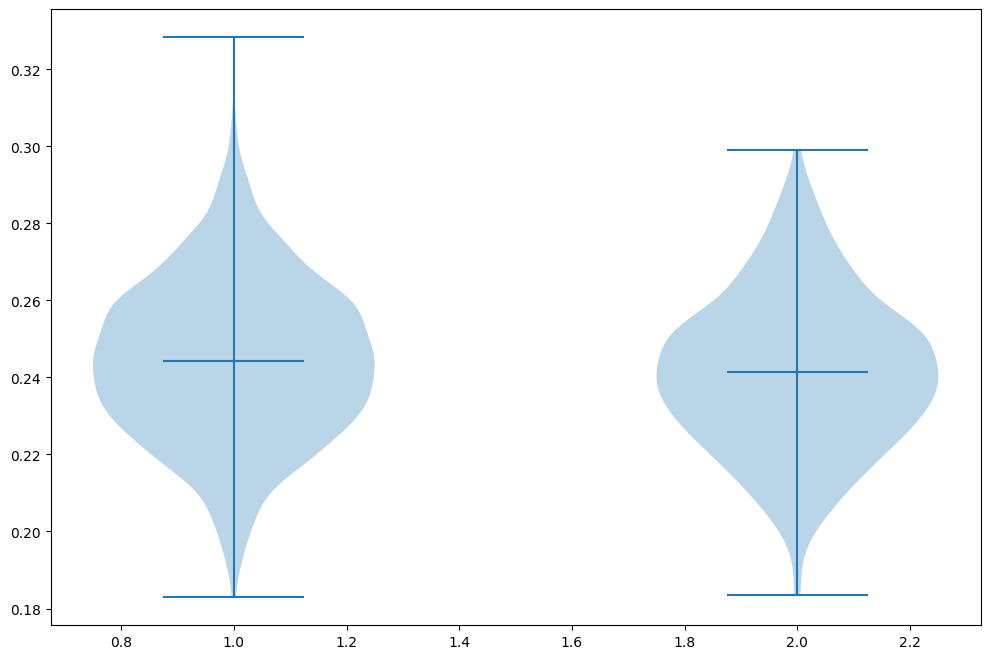

In [84]:


plt.clf()
plt.violinplot(
    [dyad_b1, nyad_b1],
    showmeans=True,
#     showmedians=True,
)
plt.show()



In [86]:
from scipy.stats import ttest_ind

In [87]:
statistic, pvalue = ttest_ind(
    dyad_b1,
    nyad_b1)

In [88]:
statistic

2.865355132843717

In [89]:
print("P Value for Real vs. False Dyads:", pvalue)

P Value for Real vs. False Dyads: 0.004222790260036983


In [60]:
# load CSV from emily Hone groups
groups = pd.read_csv("/data/perlman/moochie/analysis/CARE/forperlman_rdaslist_20221101.csv")
groups['subject'] = [id.replace('-', '') for id in groups['record_id']]
groups.set_index('subject', inplace=True)

In [61]:
groups

,famid,record_id,rdas_group,enroll_group
subject,,,,
50001,5000,5000-1,Conflict,Divorce
50021,5002,5002-1,Non-Conflict,Control
50031,5003,5003-1,Non-Conflict,Control
50032,5003,5003-2,Non-Conflict,Control
50071,5007,5007-1,Non-Conflict,Control
...,...,...,...,...
51511,5151,5151-1,Conflict,Divorce
51521,5152,5152-1,Non-Conflict,Control
51531,5153,5153-1,Conflict,Divorce


In [89]:
# load CSV from emily Hone's RDAS scores
scores = pd.read_csv("/data/perlman/moochie/analysis/CARE/forkhalil_fullscored.csv")
scores['subject'] = [id.replace('-', '') for id in scores['record_id']]
scores.set_index('subject', inplace=True)
scores.drop(columns=['record_id'], inplace=True)
scores = scores.astype({'famid': 'str'})

In [91]:
scores

,famid,subid,consensus,satisfaction,cohesion,total
subject,,,,,,
50021,5002,1,27,17,13,57
50091,5009,1,29,20,15,64
50092,5009,2,29,20,15,64
50111,5011,1,25,18,11,54
50181,5018,1,29,17,15,61
...,...,...,...,...,...,...
51431,5143,1,18,9,15,42
51441,5144,1,11,3,4,18
51471,5147,1,20,14,11,45


In [94]:
scores.columns

Index(['famid', 'subid', 'consensus', 'satisfaction', 'cohesion', 'total'], dtype='object')

In [96]:
# see how many rows there are in there
# weird number, huh?
# it's because not everybody has RDAS data :(
len([id for id in scores.index])

112

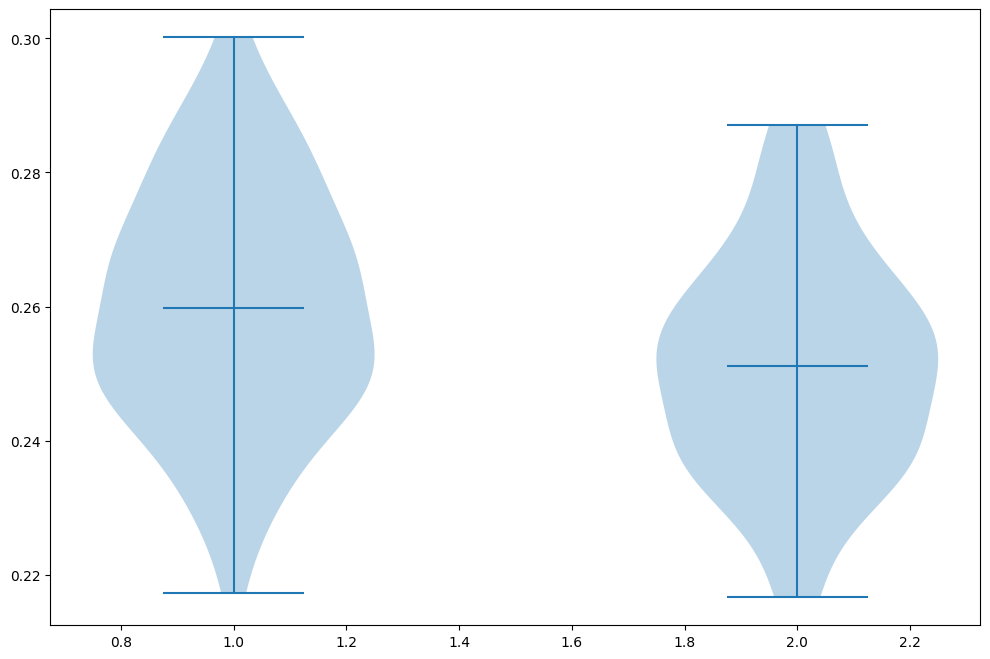

T stat: 2.7066014063581245 
 P value: 0.007732759681705392


In [97]:
group1syncs = [] # get synchrony from all of groups 1 (control)
group2syncs = [] # get synchrony from problem group

# set which channels you want to include in the avg. by commenting / uncommenting lines here
# tip: use ctrl-forward slash to comment or uncomment a line or group of lines!

channels = [
#     'S3_D2 hbo', # left frontal
    'S4_D2 hbo',
    'S5_D3 hbo', # right frontal
#     'S6_D3 hbo',
#     'S1_D1 hbo', # left temporal
#     'S2_D1 hbo',
#     'S2_D2 hbo',
#     'S7_D3 hbo', #right temporal
#     'S7_D4 hbo',
#     'S8_D4 hbo'
]

for sub in sync_df.keys():
    avgsync = np.average([
        sync_df[sub][sub.replace('p', 'c')]['Block 2'][ch] for ch in channels])
    
    if (groups.loc[[sub.replace('p', '')]]['enroll_group'][0] == "Control") and \
        (groups.loc[[sub.replace('p', '')]]['rdas_group'][0] == "Non-Conflict"):
        group1syncs.append(avgsync)
    else:
        group2syncs.append(avgsync)
        
plt.clf()
plt.violinplot(
    [group1syncs, group2syncs],
    showmeans=True)
plt.show()

statistic, pvalue = ttest_ind(
    group1syncs,
    group2syncs)

print("T stat:", statistic, "\n", "P value:", pvalue)

In [98]:
np.std(group2syncs)

0.016444974052242916

In [99]:
# enrollment group 2 OR above RDAS critical value == conflict group

In [100]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats.mstats import winsorize

In [101]:
blocks = {
    'Block 1': 'Pre-Play',
    'Block 2': 'Puzzle',
    'Block 3': 'Post-Play',
}

COIs = [
    'consensus',
    'satisfaction',
    'cohesion',
#     'total'
]

channels = [
#     'S3_D2 hbo', # left frontal
    'S4_D2 hbo',
    'S5_D3 hbo', # right frontal
#     'S6_D3 hbo',
#     'S1_D1 hbo', # left temporal
#     'S2_D1 hbo',
#     'S2_D2 hbo',
#     'S7_D3 hbo', #right temporal
#     'S7_D4 hbo',
#     'S8_D4 hbo'
]

In [102]:
list(sync_df.keys())[0]

'50001p'

In [103]:
# for block_num in blocks.keys():
#     block_name = blocks[block_num]

#     syncs = [np.average([
#     #     (sync_df[parent][parent.replace('p', 'c')]['Block 2'][ch] - sync_df[parent][parent.replace('p', 'c')]['Block 1'][ch]) \
#         sync_df[parent][parent.replace('p', 'c')][block_num][ch] \
#             for ch in channels]) for parent in sync_df.keys() \
#                 if parent.replace('p', '')[:-1] in list(scores['famid'])]
    
#     for COI in COIs:
        
# #         rdas = [scores.loc[[sub]][COI][0] for sub in [sub.replace('p', '') for sub in sync_df.keys() \
# #             if sub.replace('p', '')[:-1] in list(scores['fam_id'])]]
        
#         rdas = []
#         for sub in sync_df.keys():
#             if sub.replace('p', '')[:-1] in list(scores['famid']):
#                 rdas.append(
#                     scores[scores['famid'] == sub.replace('p', '')[:-1]][COI][0])
#             else:
# #                 rdas.append(np.nan)
#                 print("No RDAS data for:", sub)
#                 print("Group:", groups[sub.replace('p', '')])

#         xnan = np.array(rdas, dtype='float')
#         ynan = np.array(syncs, dtype='float')
        
# #         # get IQR
# #         q75, q25 = np.percentile(xnan, [75, 25])
# #         intr_qr = q75 - q25
# #         qmax = q75 + (1.5 * intr_qr)
# #         qmin = q25 - (1.5 * intr_qr)
        
# #         # remove the extra-IQR vals
# #         xnan[xnan < qmin] = qmin
# #         xnan[xnan > qmax] = qmin


    
#         x = np.delete(xnan, np.where(np.isnan(xnan)))
#         y = np.delete(ynan, np.where(np.isnan(xnan)))
        
#         print("x shape:", x.shape)
#         print("y shape:", y.shape)
        
#         # winsorize(y, inplace=True, limits=[0.05, 0.05])
#         # winsorize(x, inplace=True, limits=[0.05, 0.05])
        
#         X = x
#         Y = y
        
#         x = x.reshape(-1, 1)

#         model = LinearRegression().fit(x, y)
        
#         r_sq = model.score(x, y)
#         print(f"Coefficient of Determination: {r_sq}")
#         print(f"intercept: {model.intercept_}")
#         print(f"slope: {model.coef_}")
        
#         plt.clf()
#         # plot data
#         plt.scatter(
#             x,
#             y,
#             color='black')
#         # plot regression line
#         plt.plot(
#             np.linspace(np.min(x), np.max(x)),
#             model.predict(np.linspace(np.min(x), np.max(x)).reshape(-1, 1)),
#             color='blue',
#             linewidth=3)
#         plt.xlabel(f"RDAS {COI.upper()}")
#         plt.ylabel(f"Dyadic Synchrony in {block_name}")
#         plt.title(f"{block_name}: {COI}")

#         plt.show()
# #         plt.savefig(
# #             f"/data/perlman/moochie/analysis/CARE/{block_name}_RDAS_{COI}.png",
# #             dpi=100)

#         X2 = sm.add_constant(X)
#         est = sm.OLS(Y, X2)
#         est2 = est.fit()
#         print(est2.summary())

Coefficient of Determination: 0.045943867613540634
intercept: 0.24335276267275804
slope: [0.00060838]


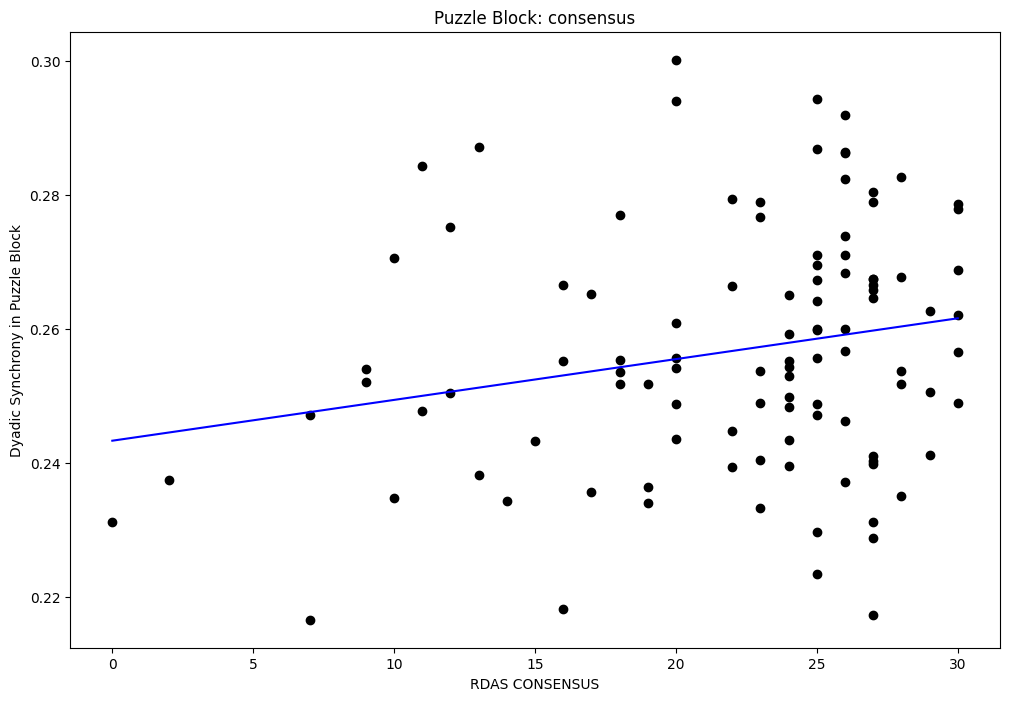

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     4.960
Date:                Fri, 11 Nov 2022   Prob (F-statistic):             0.0281
Time:                        16:39:54   Log-Likelihood:                 274.06
No. Observations:                 105   AIC:                            -544.1
Df Residuals:                     103   BIC:                            -538.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2434      0.006     38.765      0.0

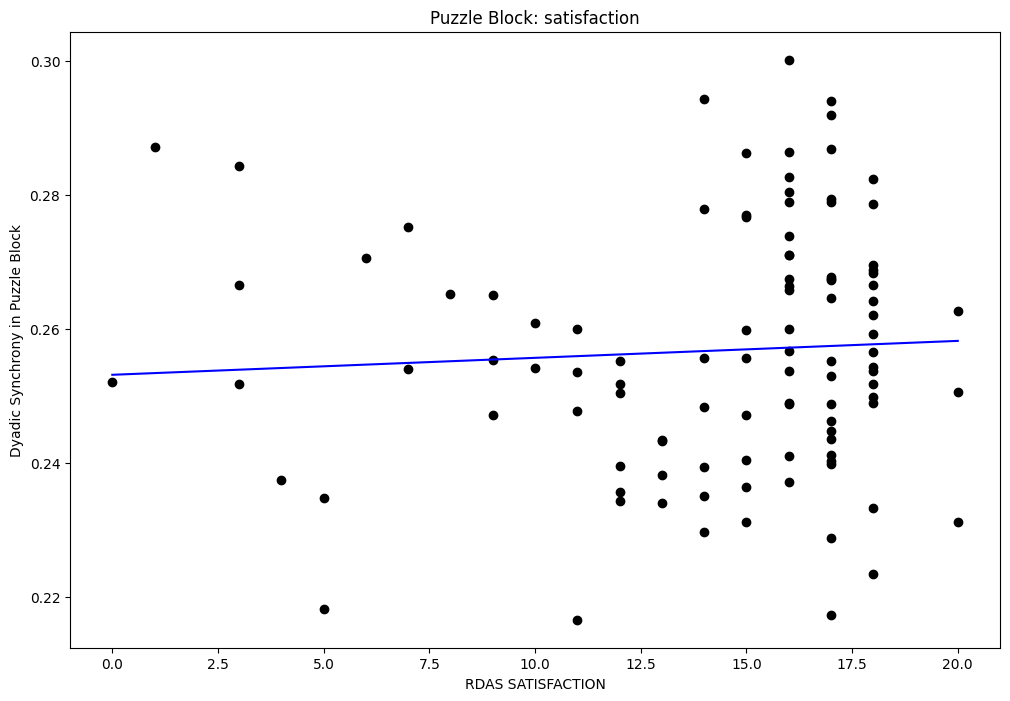

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.3781
Date:                Fri, 11 Nov 2022   Prob (F-statistic):              0.540
Time:                        16:39:54   Log-Likelihood:                 271.78
No. Observations:                 105   AIC:                            -539.6
Df Residuals:                     103   BIC:                            -534.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2532      0.006     41.390      0.0

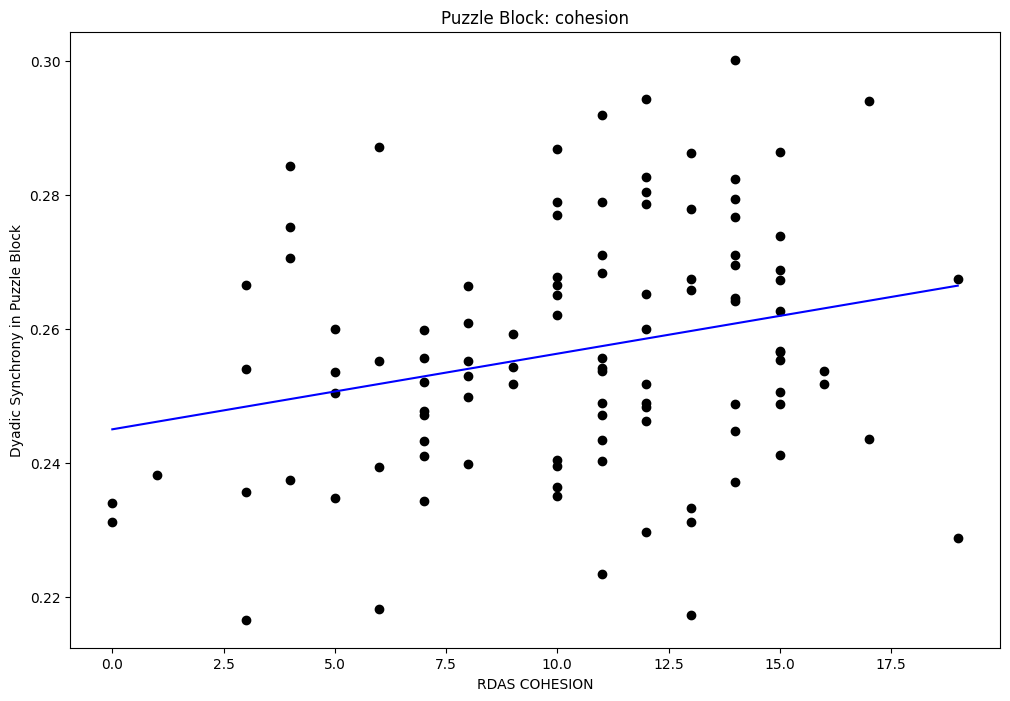

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     7.109
Date:                Fri, 11 Nov 2022   Prob (F-statistic):            0.00891
Time:                        16:39:54   Log-Likelihood:                 275.09
No. Observations:                 105   AIC:                            -546.2
Df Residuals:                     103   BIC:                            -540.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2451      0.005     51.826      0.0

In [104]:
# syncs = [
#     sync_df[parent][parent.replace('p', 'c')]['Block 3']['S7_D3 hbo'] - sync_df[parent][parent.replace('p', 'c')]['Block 1']['S7_D3 hbo'] \
#         for parent in list(sync_df.keys()) \
#             if parent.replace('p', '') in list(scores.index)]
channels = [
#     'S3_D2 hbo', # left frontal
    'S4_D2 hbo',
    'S5_D3 hbo', # right frontal
#     'S6_D3 hbo',
#     'S1_D1 hbo', # left temporal
#     'S2_D1 hbo',
#     'S2_D2 hbo',
#     'S7_D3 hbo', #right temporal
#     'S7_D4 hbo',
#     'S8_D4 hbo'
]

# block_num = 'Block 1'
block_name = 'Puzzle Block'

# syncs = [np.average([
#     list(sync_df[parent][parent.replace('p', 'c')][block_num][ch]) for ch in frontal_channels]) \
#         for parent in list(sync_df.keys()) \
#             if parent.replace('p', '') in list(scores.index)]

syncs = [np.average([
#     (sync_df[parent][parent.replace('p', 'c')]['Block 2'][ch] - sync_df[parent][parent.replace('p', 'c')]['Block 1'][ch]) \
    sync_df[parent][parent.replace('p', 'c')]['Block 2'][ch] \
        for ch in channels]) for parent in sync_df.keys() \
            if parent.replace('p', '') in list(scores.index)]

for COI in COIs:

    rdas = [scores.loc[[sub]][COI][0] for sub in [sub.replace('p', '') for sub in sync_df.keys() \
        if sub.replace('p', '') in list(scores.index)]]

    xnan = np.array(rdas, dtype='float')
    ynan = np.array(syncs, dtype='float')

#         # get IQR
#         q75, q25 = np.percentile(xnan, [75, 25])
#         intr_qr = q75 - q25
#         qmax = q75 + (1.5 * intr_qr)
#         qmin = q25 - (1.5 * intr_qr)

#         # remove the extra-IQR vals
#         xnan[xnan < qmin] = qmin
#         xnan[xnan > qmax] = qmin

    x = np.delete(xnan, np.where(np.isnan(xnan)))
    y = np.delete(ynan, np.where(np.isnan(xnan)))

    # winsorize(y, inplace=True, limits=[0.05, 0.05])
    # winsorize(x, inplace=True, limits=[0.05, 0.05])

    X = x
    Y = y

    x = x.reshape(-1, 1)

    model = LinearRegression().fit(x, y)

    r_sq = model.score(x, y)
    print(f"Coefficient of Determination: {r_sq}")
    print(f"intercept: {model.intercept_}")
    print(f"slope: {model.coef_}")

    plt.clf()
    # plot data
    plt.scatter(
        x,
        y,
        color='black')
    # plot regression line
    plt.plot(
        np.linspace(np.min(x), np.max(x)),
        model.predict(np.linspace(np.min(x), np.max(x)).reshape(-1, 1)),
        color='blue',
        linewidth=1.5)
    plt.xlabel(f"RDAS {COI.upper()}")
    plt.ylabel(f"Dyadic Synchrony in {block_name}")
    plt.title(f"{block_name}: {COI}")

    plt.show()

    X2 = sm.add_constant(X)
    est = sm.OLS(Y, X2)
    est2 = est.fit()
    print(est2.summary())